# Exploratory Data Analysis

Let's get some insights of the documents provided for the test! 

In [1]:
%load_ext autoreload
%autoreload 2

import os
from tqdm import tqdm

from loader import load_corpus_as_dataframe, load_translations_to_df
import models.base_model # Fix the seeds and enable tqdm on pandas

[nltk_data] Downloading package punkt to
[nltk_data]     /home/borjafourquet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/borjafourquet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/borjafourquet/anaconda3/envs/mt/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Load the corpus

In [2]:
df = load_corpus_as_dataframe(os.path.join("data", "documents_challenge"))

2020-08-03 23:22:11,952 INFO ea-test Loading corpus from data/documents_challenge
100%|██████████| 23128/23128 [00:00<00:00, 23451.65it/s]


In [3]:
df.head()

,context,language,docname,text
0,APR,en,apr-music-95-en.txt,"here is a live optimum quality, not one of tho..."
1,APR,en,apr-book-295-en.txt,i read this book without having read anything ...
2,APR,en,apr-book-682-en.txt,the edition is from 2008 and not 1998 how you ...
3,APR,en,apr-book-302-en.txt,very probably the worst easton ellis i read .....
4,APR,en,apr-dvd-1997-en.txt,despite a healthy dose of subjectivity in favo...


#### Number of documents in the corpus

In [13]:
print(f"{len(df)} total documents in the corpus")

23128 total documents in the corpus


#### Number of documents grouped by language

In [5]:
df.language.value_counts().to_frame()

,language
en,9724
fr,8236
es,5168


#### Number of documents grouped by context
Do the same for the context column. This will be our target column and there is obviously a class imbalance, as "Conference_papers" has few samples compared to "Wikipedia", for example

In [8]:
df.context.value_counts().to_frame()

,context
Wikipedia,13588
APR,6000
PAN11,2920
Conference_papers,620


#### Number of documents grouped by docname

In [9]:
df.docname.value_counts().to_frame()

,docname
1068893398-es.txt,1
pan-4-4-en.txt,1
apr-book-733-fr.txt,1
1607369431-fr.txt,1
16311489-fr.txt,1
...,...
apr-dvd-633-fr.txt,1
1551739730-fr.txt,1
pan-238-24-en.txt,1
544527039-fr.txt,1


## Preprocessing

### Clean the text

Some of the documents have a lot of unwanted characters on them, specially those coming from Wikipedia, like unparsed tabular data, URLs, references to articles in other languages... 

The text cleaning performed is far from perfected, but at least it removes some tabular data, words that are too long (probably because a concatenation without spaces of multiple words) and removing URLs

In [31]:
df.iloc[10000].text

"Angular acceleration is the rate of change of angular velocity over time. In SI units, it is measured in radians per second squared (rad/s2), and is usually denoted by the Greek letter alpha (\\,).Mathematical definitionThe angular acceleration can be defined as either: = \\frac = \\frac , or  = \\frac_ ,where  is the angular velocity, \\mathbf_ is the linear tangential acceleration, and r is the radius of curvature.Equations of motionFor rotational motion, Newton's second law can be adapted to describe the relation between torque and angular acceleration: = I\\  ,where  is the total torque exerted on the body, and I is the mass moment of inertia of the body.Constant accelerationFor all constant values of the torque, , of an object, the angular acceleration will also be constant. For this special case of constant angular acceleration, the above equation will produce a definitive, constant value for the angular acceleration: = \\frac .Non-constant accelerationFor any non-constant torqu

In [33]:
from preprocess.clean import clean_text

df = clean_text(df)

"Angular acceleration is the rate of change of angular velocity over time. In SI units, it is measured in radians per second squared (rad/s2), and is usually denoted by the Greek letter alpha (\\,).Mathematical definitionThe angular acceleration can be defined as either: = \\\\frac , or  = \\frac_ ,where  is the angular velocity, \\mathbf_ is the linear tangential acceleration, and r is the radius of curvature.Equations of motionFor rotational motion, Newton's second law can be adapted to describe the relation between torque and angular acceleration: = I\\  ,where  is the total torque exerted on the body, and I is the mass moment of inertia of the body.Constant accelerationFor all constant values of the torque, , of an object, the angular acceleration will also be constant. For this special case of constant angular acceleration, the above equation will produce a definitive, constant value for the angular acceleration: = \\frac .Non-constant accelerationFor any non-constant torque, the 

In [ ]:
df.iloc[10000].cleaned_text

### Detect the language

In the corpus we have the language available, but it won't be provided when predicting the context of the documents after training the model. Therefore, we need a way of detecting the language

In [35]:
from preprocess.detect_language import detected_language

df = detected_language(df)
df.head()

,context,language,docname,text,cleaned_text,detected_language
0,APR,en,apr-music-95-en.txt,"here is a live optimum quality, not one of tho...","here is a live optimum quality, not one of tho...",en
1,APR,en,apr-book-295-en.txt,i read this book without having read anything ...,i read this book without having read anything ...,en
2,APR,en,apr-book-682-en.txt,the edition is from 2008 and not 1998 how you ...,the edition is from 2008 and not 1998 how you ...,en
3,APR,en,apr-book-302-en.txt,very probably the worst easton ellis i read .....,very probably the worst easton ellis i read .....,en
4,APR,en,apr-dvd-1997-en.txt,despite a healthy dose of subjectivity in favo...,despite a healthy dose of subjectivity in favo...,en


Around 500 documents with a mismatch in the language... we will get back to this if the accuracy of the model is not acceptable

In [37]:
(df.language != df.detected_language).value_counts()

False    22596
True       532
dtype: int64

## Load the translated documents

As mentioned in the README.md, the documents have been translated to Spanish. Let's load the translations into the dataframe

In [48]:
df = load_translations_to_df(df, os.path.join("data", "translations_es"))

In [49]:
df.translated_text.isnull().value_counts()

False    23115
True        13
Name: translated_text, dtype: int64

### Normalize the document

In [53]:
from preprocess.normalize import normalize_document

df["normalized_text"] = df.translated_text.progress_apply(normalize_document)
df = df[df.normalized_text.apply(lambda x: len(x) if x else 0) > 0]

100%|██████████| 23128/23128 [01:05<00:00, 351.43it/s]
2020-08-03 23:59:27,322 INFO numexpr.utils NumExpr defaulting to 8 threads.


In [54]:
len(df)

23115

In [55]:
df[["normalized_text"]]

,normalized_text
0,"[poseído, !, dirigible, extra, música, amantes..."
1,"[parecen, vida, ., tripas, veces, caras, perio..."
2,"[hermoso, ., 2008, pourqoi, anuncio, ?, saludo..."
3,"[``, ., violencia, peor, '', easton, ellis, ta..."
4,"[escenas, seducción, angustioso, pesar, bastan..."
...,...
23123,"[juegan, puestos, típico, reggie, miller, ser,..."
23124,"[``, voladora, arma, wier, rectas, caza, orige..."
23125,"[glenneg.sus, glénclénac, erigice, llaman, mun..."
23126,"[simbo, hecho, color.el, asociaba, pasiones, o..."


### Plot the word frequencies

In [62]:
from collections import Counter

word_counter = Counter()

for tokenized_document in df.normalized_text.tolist():
    word_counter.update(tokenized_document)
word_counter

Counter({'poseído': 36,
         '!': 3564,
         'dirigible': 6,
         'extra': 76,
         'música': 1370,
         'amantes': 156,
         'documento': 186,
         'aquí': 1433,
         'rock': 698,
         'putrefacto': 3,
         'particular': 946,
         'vivo': 439,
         'bootleg': 13,
         '1': 1650,
         'fans': 292,
         '70': 334,
         'zep': 7,
         'óptima': 19,
         ',': 21761,
         "'s": 1025,
         'calidad': 695,
         'parecen': 292,
         'vida': 2450,
         '.': 20766,
         'tripas': 33,
         'veces': 2229,
         'caras': 127,
         'periodistas': 54,
         'libe': 1,
         'autores': 312,
         'buen': 1030,
         ';': 5937,
         'ser': 4349,
         'claras': 95,
         'editores': 68,
         'leído': 251,
         'tomado': 315,
         'historias': 321,
         'esperar': 284,
         'gran': 3883,
         'oleada': 22,
         'descubrimiento': 259,
         'enca

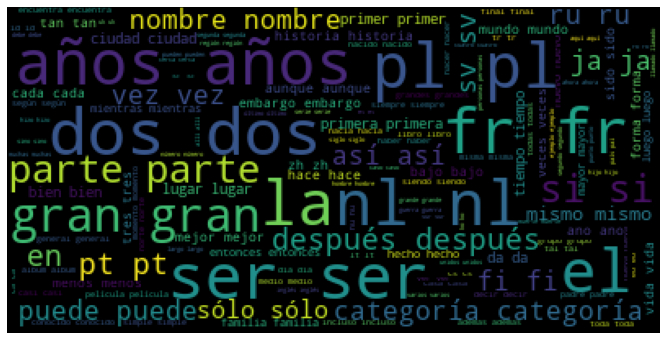

In [68]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (40, 6)

from os import path
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=40).generate(" ".join([(k + ' ') * v for k,v in word_counter.items()]))
plt.figure()
plt.imshow(wordcloud) #, interpolation="bilinear")
plt.axis("off")
plt.show()